In [7]:
# Just take all width for viz if you have a wide screen like me.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Use findspark to set Pyspark in sys.path
import findspark
findspark.init()

# import pyspark dependencies
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import Window

import os

In [2]:
spark = SparkSession \
    .builder \
    .master('local[*]') \
    .config("spark.driver.memory", "10g") \
    .appName("steam-analysis-eda") \
    .getOrCreate()

In [79]:
%%bash
# Just a cell to allow bash interactions without bash in webui


ls ../data/extracts

sales.json
steam-dataset-distinct-names
steam-dataset_games_28-12
steam-dataset_games_28-12_2
steam-dataset_games_28-12_3
steam-dataset_games_28-12_4
steam-dataset_games_28-12_5
steam-reviews-arstechnica.parquet
steam-reviews.parquet


In [3]:
dataset_path = os.path.join(os.path.dirname(os.path.realpath("")), "data/")

schema = StructType([
    StructField('#', IntegerType()),
    StructField('appid', IntegerType()),
    StructField('title', StringType()),
    StructField('release', DateType()),
    StructField('players', IntegerType()),
    StructField('owners', IntegerType()),
    StructField('total_hours', StringType()),
    StructField('developer', StringType()),
    StructField('publisher', StringType())
])

df = spark.read.csv("file://" + dataset_path + "arstechnica/arstechnica_games_sales_1.csv", header = True, schema = schema)

# Lower column names
df = df.select(
    *[df[col].alias(col.lower()) for col in df.columns]
)

df.printSchema()

df.show(5, truncate = False)

df.describe().show()

root
 |-- #: integer (nullable = true)
 |-- appid: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- release: date (nullable = true)
 |-- players: integer (nullable = true)
 |-- owners: integer (nullable = true)
 |-- total_hours: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- publisher: string (nullable = true)

+---+------+---------------------+-------+-------+--------+-----------+----------------+---------------------+
|#  |appid |title                |release|players|owners  |total_hours|developer       |publisher            |
+---+------+---------------------+-------+-------+--------+-----------+----------------+---------------------+
|1  |304930|Unturned             |null   |9099669|12226095|100073000  |Nelson Sexton   |Smartly Dressed Games|
|2  |301520|Robocraft            |null   |3549730|5344712 |56569900   |Freejam         |Freejam              |
|3  |227940|Heroes & Generals    |null   |2779196|4442318 |22875900   |Reto-Moto       |R

<AxesSubplot:>

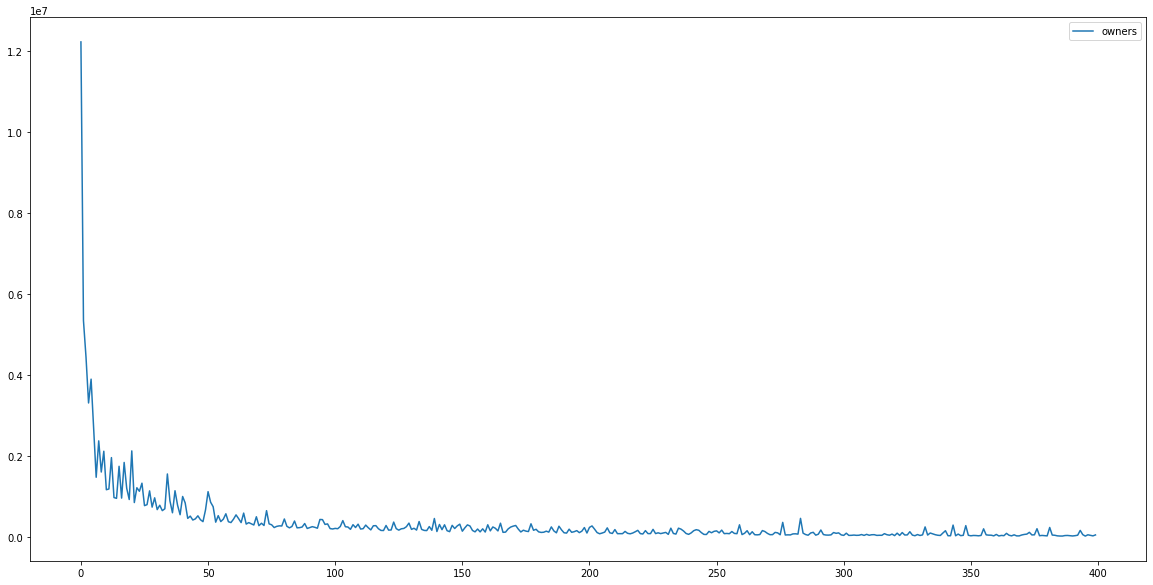

In [34]:
df.select('owners').toPandas().plot(figsize = (20,10))

In [73]:
df.sort(F.col('players').desc()).show(truncate = False)

+------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
spark \
    .sql('SELECT * FROM parquet.`{}` LIMIT 1' \
    .format("file://" + dataset_path + "extracts/steam-reviews.parquet")) \
    .printSchema()

revsum_df = spark \
    .sql(
        """SELECT
        appid,
        total_reviews
        FROM parquet.`{}`""" \
    .format("file://" + dataset_path + "extracts/steam-reviews.parquet"))

revsum_df \
    .sort(F.col('total_reviews').desc()) \
    .show()

root
 |-- appid: string (nullable = true)
 |-- cursor: string (nullable = true)
 |-- reviews: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author: struct (nullable = true)
 |    |    |    |-- last_played: long (nullable = true)
 |    |    |    |-- num_games_owned: long (nullable = true)
 |    |    |    |-- num_reviews: long (nullable = true)
 |    |    |    |-- playtime_at_review: long (nullable = true)
 |    |    |    |-- playtime_forever: long (nullable = true)
 |    |    |    |-- playtime_last_two_weeks: long (nullable = true)
 |    |    |    |-- steamid: string (nullable = true)
 |    |    |-- comment_count: long (nullable = true)
 |    |    |-- developer_response: string (nullable = true)
 |    |    |-- language: string (nullable = true)
 |    |    |-- received_for_free: boolean (nullable = true)
 |    |    |-- recommendationid: string (nullable = true)
 |    |    |-- review: string (nullable = true)
 |    |    |-- steam_purchase: boolean 

In [49]:
df \
    .withColumn('appid', F.col('appid').cast(IntegerType())) \
    .join(revsum_df, on = ['appid'], how = "inner") \
    .dropna() \
    .show()

+-----+---+-----+-------+-------+------+-----------+---------+---------+-------------+
|appid|  #|title|release|players|owners|total_hours|developer|publisher|total_reviews|
+-----+---+-----+-------+-------+------+-----------+---------+---------+-------------+
+-----+---+-----+-------+-------+------+-----------+---------+---------+-------------+



In [52]:
revsum_df \
     .withColumn('appid', F.col('appid').cast(IntegerType())) \
    .filter(F.col('appid') == 105600) \
    .show()

+------+-------------+
| appid|total_reviews|
+------+-------------+
|105600|       293631|
+------+-------------+



In [25]:
output_filename = "steam-reviews-arstechnica"

distinct_appid = df.select('appid').distinct().rdd.map(lambda x: x.appid).collect()

In [22]:
import os
import json
import requests
from tqdm import tqdm_notebook

def get_reviews(appid):
    url = 'http://store.steampowered.com/appreviews/{appid}?json=1'
    r = requests.get(url.format(appid = appid, ))
    if r.status_code == 200:
        return r.json()
    else:
        return {"status" : "error", "msg" : "error while fetching API"}
    
    
res = []
for appid in tqdm_notebook(distinct_appid):
    data = get_reviews(appid)
    data['appid'] = appid # attach appid for join
    res.append(data)
    
with open(dataset_path + "extracts/reviews.json", 'w') as f:
    json.dump(res, f, indent = 4)

/home/neadex/steam-analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


In [75]:
# To delete after verification

dataset_path = os.path.join(os.path.dirname(os.path.realpath("")), "data/")

rev_df = spark.read.json("file://" + dataset_path + "extracts/reviews.json", multiLine=True)

# Use window function to rank each row for each group (windowed on 'appid' values)
window = Window.partitionBy(rev_df['appid']).orderBy(rev_df['query_summary.total_reviews'].desc())

# Keep only queries with maximum reviews
rev_df = rev_df \
    .select('*', F.rank().over(window).alias('rank')) \
    .filter(F.col('rank') == 1) \
    .dropDuplicates()

# Drop duplicates based on total_reviews
rev_df = rev_df \
    .select('*', 'query_summary.*') \
    .dropDuplicates(['total_reviews']) \
    .drop('query_summary') \
    .drop('rank')

# Write cleaned reviews as parquet file
rev_df \
    .write \
    .mode('overwrite') \
    .parquet("file://" + dataset_path + "extracts/{}.parquet".format(output_filename))

print('DataFrame correctly saved to disk !')

os.remove(dataset_path + "extracts/reviews.json")
print('Correctly cleaned json file after dataframe save !')

AnalysisException: Path does not exist: file:/home/neadex/steam-analysis/data/extracts/reviews.json;

In [ ]:
rev_df = spark.read.parquet("file://" + dataset_path + "extracts/{}.parquet".format(output_filename))

df = rev_df \
    .join(df, on = ["appid"])

df.show()

In [ ]:
print('Number of games :', df.count())

df.sort(F.col('players').desc()).show()

In [ ]:
df.sort(F.col('players')).show()

In [ ]:
df.sort(F.col('total_positive')).show()

In [ ]:
sales_per_review = df \
    .select('appid', 'title', (F.col('owners') / F.col('total_reviews')).alias('sales_per_review')) \
    .sort(F.col('sales_per_review')) \
    .toPandas()['sales_per_review']

In [ ]:
import plotly.express as px

fig = px.bar(sales_per_review, y='sales_per_review')
fig.show()